In [288]:
#math and linear algebra stuff
import numpy as np
import numpy.linalg as la

#plots
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (15.0, 15.0)
mpl.rc('text', usetex = True)
import matplotlib.pyplot as plt
%matplotlib inline

# Fixed Point iteration methods

Fixed point iteration method stand for a very large class of algorithm that aims at iteratively solving a fixed point problem of the form $AX=B$ with $A$ an operator, and $B$ a given set of data.

In this short report, we will only be studying the case where $A$ is a linear operator represented by a square matrix.

## Jacobi and Gauss-Seidel methods

### Jacobi Method
	 
Jacobi and Gauss-Seidel method assume that one can decompose the $n \times n$ matrix $M$ into a sum of matrices $M = G + H$ where $G$ is full rank, and easily invertible, for instance it is set to a diagonal matrix in the Jacobi method.

Anyway, this lead us to a fixed point search in the high dimensional space $\mathbb{R}^n$:

\begin{align*}
    M \vec{x} - \vec{y} &= 0\\
    G \vec{x} + H \vec{x} &= \vec{y} \\
    G \vec{x} &= -H \vec{x} + \vec{y} \\
    \vec{x} &= - G^{-1} H \vec{x} + G^{-1} \vec{y} \\
    \vec{x} &= M' \vec{x} + \vec{y'}
\end{align*}
	
Where $M' = - G^{-1} H$ and $\vec{y'} = G^{-1} \vec{y}$.

This fixed point search can be carried out using a simple iterative scheme
	
\begin{equation}
  \vec{x^{k+1}} = M' \vec{x^k} + \vec{y'}
\end{equation}

or

\begin{equation}
  \vec{x^{k+1}} = G^{-1} \left( \vec{y} - H \vec{x^k} \right)
\end{equation}

According to the Picard fixed point theorem, this class of algorithm converges if the operator $T : \vec{x} \rightarrow M' \vec{x} + \vec{y'}$ is a strict contraction, i.e if there exists $\rho \in [0,1[$ such that

\begin{align*}
    \forall (x,x') \in \mathbb{R}^n \times \mathbb{R}^n, x \neq x' :\quad &\|Tx - Tx'\| \leq \rho \|x-x'\| \\
    &\|M'x + \vec{y'} - M'x' - \vec{y'}\| \leq \rho \|x-x'\| \\
    &\|M'x - M'x'\| \leq \rho \|x-x'\| \\
    &\|M' (x - x')\| \leq \rho \|x-x'\| \\
    &\|M'\| \|(x - x')\| \leq \rho \|x-x'\| \\
    &\|M'\| \leq \rho
\end{align*}

This condition can be interpreted as a $[0,1[$-Lipshitz continuity property of the linear application $M'$, which is equivalent to a constraint over the operator norm of $M'$, that reduces to a constraint over its largest singular value: $0 \leq \sigma(M')_{max} < 1 $.

In [270]:
"""
Let's try to solve a simple linear system using Jacobi iterations
"""

M = np.array([[1,1,1,1],
            [1,1,4,4],
            [1,4,1,4],
            [1,4,4,1]])
Y = np.ones(M.shape[0])

print "determinant of M is "+str(np.linalg.det(M))
print "Condition number of M is "+str(np.linalg.cond(M))

#Now perform the decomposition
G = np.diag(np.diagonal(M))
H = M-G
#New variables
M1=np.dot(-np.diag(1./np.diagonal(G)),H)
Y1=np.dot(np.diag(1./np.diagonal(G)),Y)
omega = 0.2
u,lamb,vh=np.linalg.svd(M1)
spectRadM1 = lamb[0]
print "spectral radius of M1 is "+str(spectRadM1)

determinant of M is 54.0
Condition number of M is 14.5981649059
spectral radius of M1 is 8.35889894354


### Weighted Jacobi Method

The problem of the Jacobi Method is the strong assumption that $\rho(M')<1$. Because this assumption is very strong, it rarely holds, and in those case, the method behave very poorly (exponential divergence).

One of the evolution that has been proposed in various iterative methods is the over/under relaxation. The idea is simply to consider that, from the point of view of the current solution, the new iterate may be in the right direction toward the solution, but it goes too far. The simple solution is then, to pick-up the next solution between the current one, and the nex Jacobi estimate, using a convex combination of the two.

This method can be formalized this way:

\begin{align*}
      \vec{x^{k+1}} &= \omega( \underbrace{M' \vec{x^k} + \vec{y'}}_{\text{next Jacobi iterate}} ) + (1-\omega)\vec{x^{k}} \\
        &= \vec{x^{k}} + \omega \left( \underbrace{M' \vec{x^k} + \vec{y'}}_{\text{next Jacobi iterate}} - \vec{x^{k}} \right)
\end{align*}

Where we can choose $\omega>1$ to speed-up the convergence in some cases, and $\omega<1$ when the spectral radius condition does not hold, and we wish to use Jacobi method anyway. But in this case, there does not seem to be values of $\omega$ that ensure convergence.

In [271]:
"""
    Implementing the Jacobi and weighted Jacobi Method
"""
Xk=np.zeros(M.shape[1])
nbIter = 2000
i = 0
eps=1e-5

while (i<nbIter) and not np.allclose(np.dot(M,Xk),Y,atol=eps):
    nextIterate = np.dot(M1,Xk)+Y1
    #Classic jacobi method
    if( spectRadM1 < 1 ):
        Xk = nextIterate
    #Weighted jacobi method
    else:
        Xk += omega*(nextIterate - Xk)
    i += 1

if i<nbIter:
    print "Found a solution in "+str(i)+"/"+str(nbIter)+" iteration within absolute precision "+str(eps)
else:
    print "Jacobi iteration failed, residual norm is "+str(np.linalg.norm(np.dot(M,Xk)-Y))

Found a solution in 80/2000 iteration within absolute precision 1e-05


###  Successive Over-Relaxation Method (SOR)

In practice, the weighted Jacobi method is not really efficient either, Young and Frankel, derived an interesting algorithm, called Successive Over-Relaxation, or SOR, based on a simple trick we will explain later:

Let's get back to our first matrix decomposition, and slightly modify it:

\begin{align*}
    (G + Id + H) \vec{x} &= \vec{y} \\
    \omega (G + Id + H) \vec{x} &= \omega \vec{y} \\
    (G + (\omega-1)G + \omega Id + \omega H) \vec{x} &= \omega \vec{y} \\
    (G + \omega Id ) \vec{x} &= \omega \vec{y} - ((\omega-1)G + \omega H)\vec{x} \\
\end{align*}

With $\omega$ a relaxation parameter that can be used for underrelaxation ($\omega<1$) or overrelaxation ($\omega>1$).
The update equation become:
\begin{align*}
    \vec{x^{k+1}} &= - (G+\omega Id)^{-1}((\omega-1)G + \omega H)\vec{x^{k}} + \omega (G+\omega Id)^{-1}\vec{y} \\
    \vec{x^{k+1}} &= M'\vec{x} + \vec{y'}
\end{align*}

Where $M' = - (G+\omega Id)^{-1}((\omega-1)G + \omega H)$ and $\vec{y'} = \omega (G+\omega Id)^{-1}\vec{y}$.


In [285]:
"""
Implementing the SOR variation of Jacobi method
"""

#Now perform the new decomposition
G = np.diag(np.diagonal(M))
H = M-G-np.identity(H.shape[0])
omega = 0.1
gwId = np.diag(1./(np.diagonal(G)+omega))
M1=-np.dot(gwId,(omega-1.)*G+omega*H)
Y1=omega*np.dot(gwId,Y)

#Now solve
Xk=np.zeros(M.shape[1])
nbIter = 2000
i = 0
eps=1e-3

while (i<nbIter) and not np.allclose(np.dot(M,Xk),Y,atol=eps):
    #SOR Jacobi method
    Xk = np.dot(M1,Xk)+Y1
    i += 1

if i<nbIter:
    print "Found a solution in "+str(i)+"/"+str(nbIter)+" iteration within absolute precision "+str(eps)
else:
    print "Jacobi iteration failed, residual norm is "+str(np.linalg.norm(np.dot(M,Xk)-Y))


Found a solution in 107/2000 iteration within absolute precision 0.001


### Analysing the SOR trick

Where does this $\omega$ trick comes from ? Although it resemble the weighted Jacobi method, the SOR flavour is far more satisfactory from the theoretical point of view.

Let's get back to our spectral condition:

\begin{equation}
 \lambda_{max} \left( M' \right) < 1
\end{equation}

We would like to find another decomposition that would allow us to generate a $M'$ with a small spectral radius ($<1$).
What about $M' = - (G+\omega Id)^{-1}((\omega-1)G + \omega H)$ ?

We will decompose this expression as the sum of two matrices : $M_1$ and $M_2$

As both $G$ and $Id$ are diagonal, many expression simplifies
\begin{align*}
    \sigma(M_1) = & \sigma((G+\omega Id)^{-1}(\omega-1)G)\\
    = &\sigma(G+\omega Id)^{-1} \sigma((\omega-1)G)\\
    = &\frac{(\omega-1)\sigma(G)}{\sigma(G)+\omega}\\
\end{align*}

The spectral radius of this matrix can be easily controled using the value of $\omega$, see

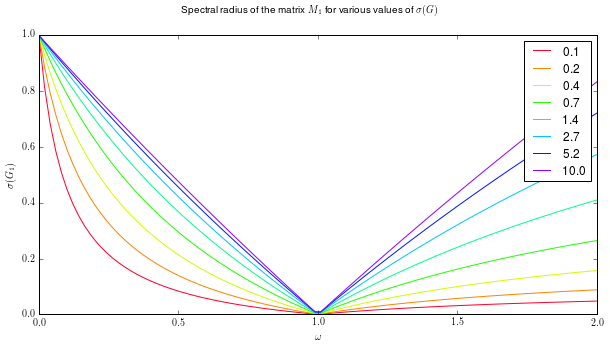

In [352]:
w = np.linspace(0,2,100)

NB_SAMPLE = 8
sigGl = np.logspace(-1,1,NB_SAMPLE)

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NB_SAMPLE) for i in range(NB_SAMPLE)]

plt.figure(figsize=(10,5))
plt.suptitle(r'\text{Spectral radius of the matrix $M_1$ for various values of $\sigma(G)$}')
plt.ylabel(r'\sigma(G_1)')
plt.xlabel(r'\omega')

for sigG,color in zip(sigGl,colors):
    s = np.abs(((w-1)*sigG)/(sigG+w))
    plt.plot(w,s,color=color,label="{0:.1f}".format(sigG))#r'\frac{\sigma(H)}{\sigma(G)} = '+
plt.legend()



And now, what about $M_2$ :

\begin{align*}
    M_2 = &(G+\omega Id)^{-1}\omega H\\
    = &((\omega+1)G)^{-1}\omega H\\
    = &\frac{\omega}{\omega+1}(G)^{-1}H\\
\end{align*}

The spectral radius of $M_2$ can be computed if $H$ is symmetric positive definite. Indeed, in this case $G$ and $H$ commutes, then they can be diagonalized in the same eigen space, and so we can make reasonning about the spectral radius of their product and sum.
In this case the spectral radius of $M_2$ can be expressed in function of $\omega$, $\sigma(G)$ and $\sigma(H)$ as:

\begin{equation}
    \sigma(M_2) = \frac{\omega}{\omega+1} \frac{\sigma(H)}{\sigma(G)}
\end{equation}

$M_1$ being diagonal, and using the same commuting argument, we can derive the spectral radius of $M_1 + M_2$
\begin{align*}
    \sigma(M_1+M_2) &= \sigma(M_1)+\sigma(M_2)\\
    &= \frac{(\omega-1)\sigma(G)}{\sigma(G)+\omega} + \frac{\omega \sigma(H)}{(\omega+1)\sigma(G)}\\
    &= \\
\end{align*}

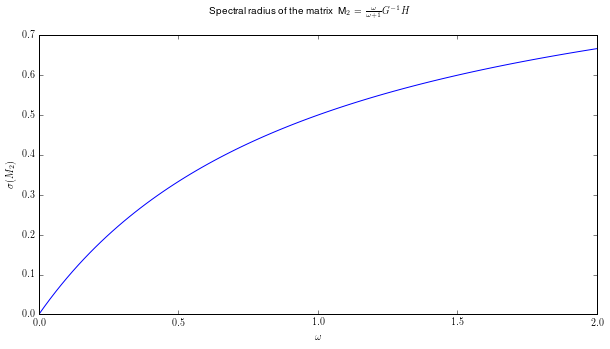

In [321]:
w = np.linspace(0,2,100)
s = np.abs(w/(w+1))

plt.figure(figsize=(10,5))
plt.suptitle(r'\text{Spectral radius of the matrix } M_2 = \frac{\omega}{\omega+1}G^{-1}H')
plt.plot(w,s)
plt.ylabel(r'\sigma(M_2)')
plt.xlabel(r'\omega')

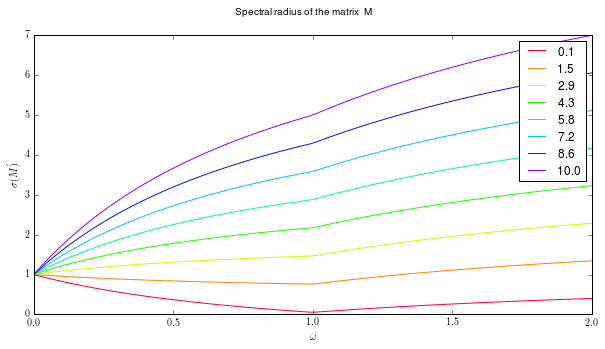

In [337]:
"""
We can now plot the spectral radius of M' for various
values of \frac{\sigma(H)}{\sigma(G)}
"""
NB_SAMPLE = 8
fracSigHG = np.linspace(1e-1,10,NB_SAMPLE)

cm = plt.get_cmap('gist_rainbow')
colors = [cm(1.*i/NB_SAMPLE) for i in range(NB_SAMPLE)]

plt.figure(figsize=(10,5))
plt.suptitle(r'\text{Spectral radius of the matrix } M\'')
plt.ylabel(r'\sigma(M\')')
plt.xlabel(r'\omega')

w = np.linspace(0,2,100)

for sigHG,color in zip(fracSigHG,colors):
    s1 = np.abs((w-1)/(w+1))
    s2 = np.abs(sigHG*w/(w+1))
    plt.plot(w,s1+s2,color=color,label="{0:.1f}".format(sigHG))#r'\frac{\sigma(H)}{\sigma(G)} = '+
plt.legend()

### Notes

In 2015, a nice refinement to the basic Jacobi method has been derived, see [https://arxiv.org/abs/1511.04292](Scheduled Relaxation Jacobi method: improvements and applications).

We can notice that the author exploited the famous Chebyshev polynomial acceleration scheme we present in the notebook called ChebyshevPolynomialAcceleration.

In our numerical experimentation, the Jacobi method as implemented here, performed really bad in most of the case with large randomized systems, it is not really recommended to use it for real life problems.

### Gauss Seidel method

In the gauss seidel method, it is assumed that the matrix $M$ can be decomposed as follows:

\begin{equation}
  M = D + (L + U)
\end{equation}

Where, $L$ is a strictly lower triangular matrix, $D$ is a non singular diagonal matrix, and $U$ is a stricly upper triangular matrix. The generic method exposed in the previous part can then be applied.


If we denote $X_i$ as the $i^{th}$ row of the matrix $X$, and $x_i$ the $i^{th}$ component of the vector $x$, we can express each Gauss Seidel algorithm as:

\begin{algorithm}
  \caption{Solve $M \vec{x} - \vec{y} = 0$}
    \begin{algorithmic}
      \REQUIRE $M = L + D + U$ and $ D_i \neq \vec{0} \forall i \in 0,1,\dots n-1$
      \STATE $x^0 \leftarrow \vec{0}$
      \WHILE{$ \| M \vec{x^k} - \vec{y} \| \geq \epsilon_{criterion}$}
    \FORALL{$i \in 0,1,\dots n-1$}
      \STATE $x_i^{k} \leftarrow \frac{y_i - \vec{L_i + D_i}.\vec{x^k}}{U_{ii}}$
    \ENDFOR
    \STATE $k \leftarrow k+1$
      \ENDWHILE
    \end{algorithmic}
\end{algorithm}

The inner loop in this algorithm, performed at each iteration, can itself be viewed as a coordinate descent method, solving the following problem:
	
\begin{align*}
  (L + D) \vec{x^k} + U \vec{x^{k+1}} - \vec{y} = 0 \\
  \vec{x^{k+1}} = U^-1 ( \vec{y} - (L + D) \vec{x^k} )
\end{align*}

### Analysis

If $M\vec{x} - \vec{y} = 0$ has a solution, the Gauss Seidel method converges if $M$ is symmetric, positive definite, or, as formalized in chapter 1 of Convex Optimization from Boyd & Vandenberghe, it lies in the positive definite cone $S^n_{++}$.

In [241]:
"""
Let's try to solve a Positive Definite (PD) linear system
using Gauss-Seidel iterations
"""
size=10
M = np.random.rand((size,size))
M = np.dot(M,M.T)
Y = np.ones(size)

#Now perform the decomposition
D = np.diag(np.diagonal(M))
ltMask = numpy.tri(L.shape[0])
L = ltMask*(M-D)
U = (1-ltMask)*M

#New variables
M1=np.dot(-np.diag(1./np.diagonal(G)),H)
Y1=np.dot(np.diag(1./np.diagonal(G)),Y)
omega = 0.2
u,lamb,vh=np.linalg.svd(M1)
spectRadM1 = lamb[0]
print "spectral radius of M1 is "+str(spectRadM1)


#Now solve
Xk=np.zeros(M.shape[1])
nbIter = 2000
i = 0
eps=1e-5

while (i<nbIter) and not np.allclose(np.dot(M,Xk),Y,atol=eps):
    nextIterate = np.dot(M1,Xk)+Y1
    #Classic jacobi method
    if( spectRadM1 < 1 ):
        Xk = nextIterate
    #Weighted jacobi method
    else:
        Xk += omega*(nextIterate - Xk)
    i += 1

if i<nbIter:
    print "Found a solution in "+str(i)+"/"+str(nbIter)+" iteration within absolute precision "+str(eps)
else:
    print "Jacobi iteration failed, residual norm is "+str(np.linalg.norm(np.dot(M,Xk)-Y))


TypeError: an integer is required